# Machine Learning Final Project: EEG-Based Brain-Computer Interface Using Machine Learning Methods

## Import Libraries

In [1]:
import mne
import scipy.io
import numpy as np
from mne.decoding import CSP
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,\
    confusion_matrix, ConfusionMatrixDisplay

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances

# Import Dataset

In [2]:
# Load .mat file containing the EEG signals
mat = scipy.io.loadmat("./BCICIV_1_mat/BCICIV_calib_ds1a.mat")
print("Variables include: ", mat.keys())

# Extract variables
cnt = mat['cnt'].astype(np.float64) * 0.1  # Converted microvolts
pos = mat['mrk']['pos'][0][0].flatten()
y = mat['mrk']['y'][0][0].flatten()

# Extract extra info
nfo = mat['nfo']
fs = nfo['fs'][0][0][0][0]
clab = [str(c[0]) for c in nfo['clab'][0][0][0]]
classes = [str(c[0]) for c in nfo['classes'][0][0][0]]
xpos = nfo['xpos'][0][0][0]
ypos = nfo['ypos'][0][0][0]

# Log
print(f"Number of time samples: {cnt.shape[0]}, Number of channels: {cnt.shape[1]}")

Variables include:  dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])
Number of time samples: 190594, Number of channels: 59


## EDA

In [3]:
def visualize_EEG(cnt, title, clab, fs, channel_num=20):
    '''Input EEG data and visualize it using mne library'''
    # Create info metavariable
    info = mne.create_info(ch_names=clab, sfreq=fs, ch_types='eeg')

    # Create RawArray object
    raw = mne.io.RawArray(cnt.T, info)

    # Plot raw EEG data
    raw.plot(n_channels=channel_num, scalings='auto', title=title, bgcolor='white', color='darkblue')

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Using matplotlib as 2D backend.


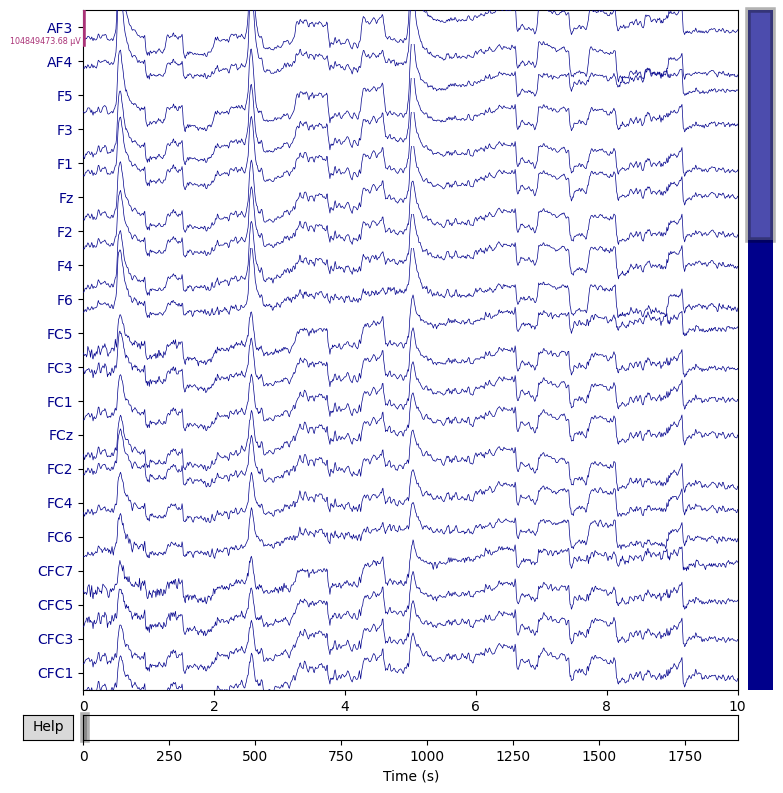

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


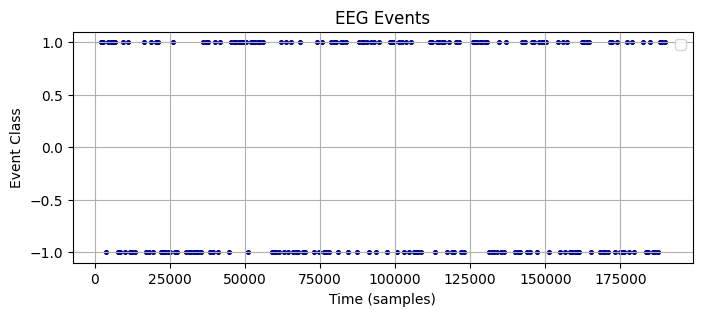

In [4]:
# Visualize raw EEG data
visualize_EEG(cnt, "Raw EEG Plot", clab, fs)

# Create a plot of events
plt.figure(figsize=(8, 3))
plt.scatter(pos, y, s=7.1, color="darkblue")
plt.xlabel('Time (samples)')
plt.ylabel('Event Class')
plt.title('EEG Events')
plt.legend()
plt.grid(True)
plt.show()

## Pre-Processing

### Band-Pass Filtering

In [5]:
def bandpass_filter(cnt, lo, hi, fs, order=3):
    tmp = 0.5 * fs
    low = lo / tmp
    high = hi / tmp
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    result = scipy.signal.lfilter(b, a, cnt, axis=0)
    return result

In [6]:
# Apply the bandpass filter for 8-30 hrz
bandpass_cnt = bandpass_filter(cnt, 8, 30, fs)

Let us take a look at the new filtered EEG signals:

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.


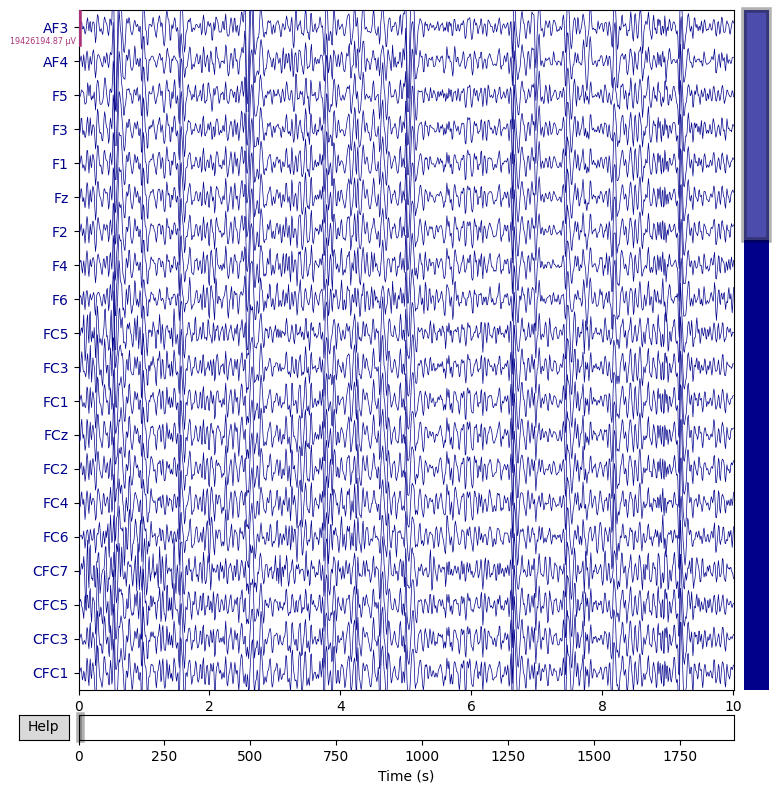

In [7]:
# Visualize bandpass filtered EEG data
visualize_EEG(bandpass_cnt, " EEG Plot", clab, fs)

### CAR
Now, we perform CAR as a spatial filter for decreasing noise and increasing the quality of the data set signals.

In [8]:
def common_average_reference(cnt):
    '''Calculate and return the CAR of given EEG data'''
    return cnt - np.mean(cnt, axis=1, keepdims=True)

In [9]:
# Apply CAR to reduce noise
CAR_cnt = common_average_reference(bandpass_cnt)

The data will look this way now:

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.


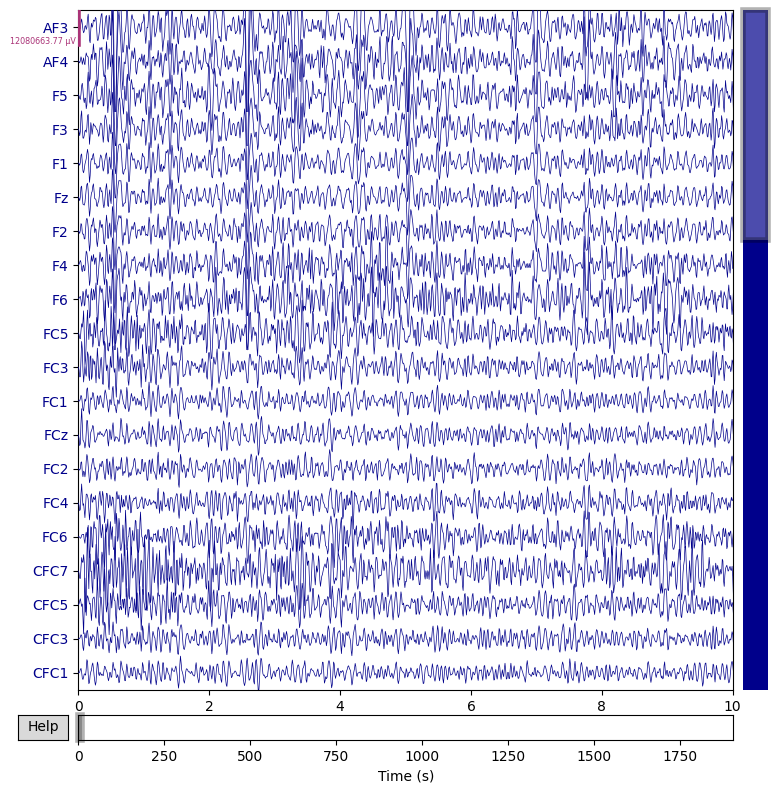

In [10]:
# Visualize bandpass filtered EEG data
visualize_EEG(CAR_cnt, "CAR Applied EEG", clab, fs)

To help understand the effects of these pre-processing methods on the data, now we will take a look at a portion of a single channel. This way, we can inspect the effects of these filters more closely.

In [11]:
def visualize_contrast(cnt_list, label_list):
    """
    Input a list of distinct EEG data and their respective names
    and plot them agains each other to display their differences
    and contrast.
    """
    fig, ax = plt.subplots(figsize=(15,6))
    for cnt, label in zip(cnt_list, label_list):
        ax.plot(cnt, label=label, linewidth=2)
    fig.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Voltage")
    ax.set_xlim(0, 500)
    fig.show()

In [12]:
# List of EEG's to visualize
cnt_list_1 = [cnt[:500, 0], bandpass_cnt[:500, 0], CAR_cnt[:500, 0]]
label_list_1 = ["Raw Signal", "Band-pass Filtered Signal", "CAR Filtered Signal"]

# Visualize them against one another
visualize_contrast(cnt_list_1, label_list_1)

C:\Users\Sardar Rajabzadeh\AppData\Local\Temp\ipykernel_2064\2360046776.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


## PCA

In [23]:
#Apply PCA to reduce dimensions
pca = PCA(n_components=10)
pca_features_after_CAR = pca.fit_transform(CAR_cnt)

In [24]:
print(pca_features_after_CAR.shape)

(190594, 10)


## Segmenting the Dataset

We will segment the dataset into different epochs around the cue positions given to us in the dataset.

In [15]:
print(type(1000))

<class 'int'>


In [16]:
def segment_data(cnt, y, a=0, b=1000):
    """
    Segment the data into different segments around the 
    cue position to perform classification on.
    
    Parameter
    ---------
    cnt : numpy.ndarray
        A 2D NumPy array of size (m, n) where 'm' is the
        number of time samples and 'n' is the number of
        EEG channels (number of electrodes).
    y : numpy.ndarray
        A 1D numpy array containing the target variables
        for each of the cue positions.
    a : int
        Number of milliseconds after cue positions to
        choose as the start of the segment.
    b : int
        Number of milliseconds after cue positions to
        choose as the end of the segment.
        
    Returns
    -------
    segments : numpy.ndarray
        A 3D NumPy array acting as a list of the 
        segments.
        
    segment_targets : numpy.ndarray
        A 1D NumPy array containing the target values.
    """
    
    # Segment start and end parameters in milliseconds.
    segment_start = a
    segment_end = b 

    # Create the segments.
    segments = []
    segment_targets = []

    # Go through every cue position.
    for i, cue_pos in enumerate(pos):
        left = cue_pos + segment_start
        right = cue_pos + segment_end
        
        # Make sure no out of bounds.
        if left >= 0 and right <= cnt.shape[0]:
            segments.append(cnt[left:right,:])
            segment_targets.append(y[i])
    
    # Return as NumPy arrays
    segments_np = np.array(segments)
    segment_targets_np = np.array(segment_targets)
    
    return segments_np, segment_targets_np

In [17]:
# Segment the data to be used for model training
seg_data, labels = segment_data(pca_features_after_CAR, y, 0, 1000)

In [18]:
print(seg_data.shape)
print(labels.shape)

(199, 1000, 10)
(199,)


### Normalization (Standardization)


In [19]:
# Initialize scaler for standardization
scaler = StandardScaler()

# Reshape the data for standardization
seg_data_reshaped = seg_data.reshape(-1, seg_data.shape[-1])

# Standardize the data
std_data_reshaped = scaler.fit_transform(seg_data_reshaped)

# Revert the data to its previous shape
std_data = std_data_reshaped.reshape(seg_data.shape)

In [20]:
print(std_data.shape)

(199, 1000, 10)


## Feature Extraction


### Common Spatial Patterns (CSP)

In [27]:
# Number of features to be extracted.
component_num = 4

# Initialize CSP for feature extraction.
csp_obj = CSP(n_components=component_num, reg='ledoit_wolf', log=True)

# Fit and apply the CSP.
csp_data = csp_obj.fit_transform(std_data, labels)

Computing rank from data with rank=None
    Using tolerance 40 (2.2e-16 eps * 1000 dim * 1.8e+14  max singular value)
    Estimated rank (data): 1000
    data: rank 1000 computed from 1000 data channels with 0 projectors
Reducing data rank from 1000 -> 1000
Estimating class=-1 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.


In [28]:
print(csp_data.shape)

(199, 4)


We can also visualize the extracted CSP features

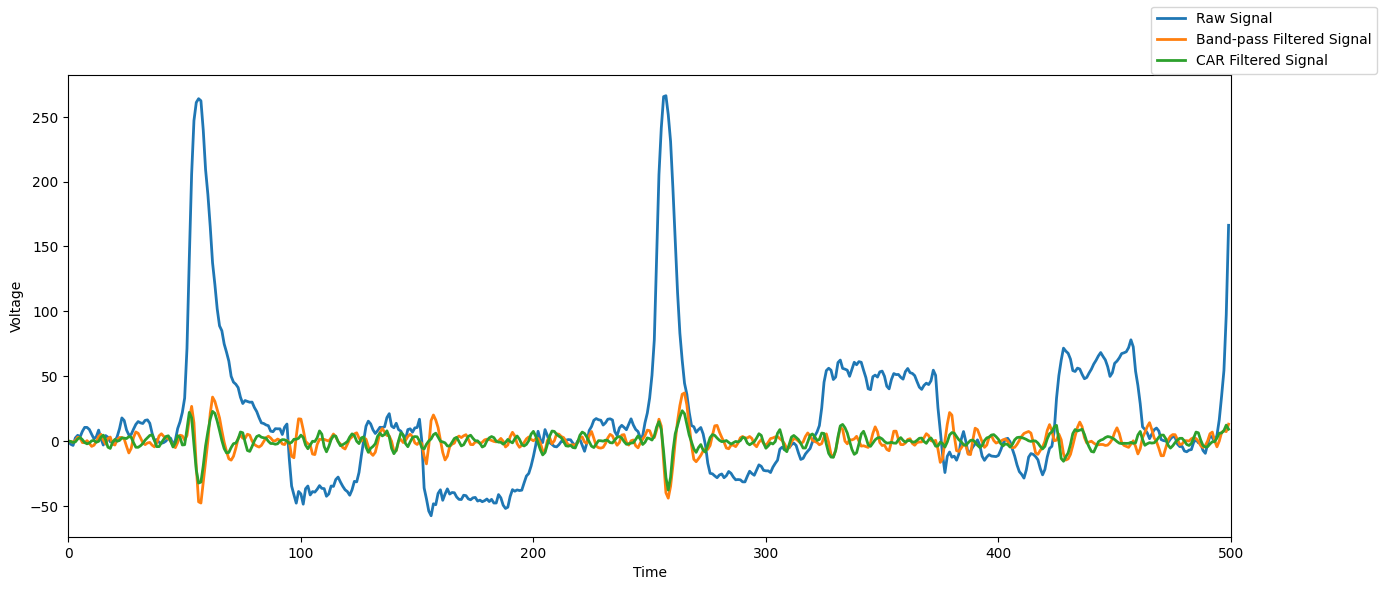

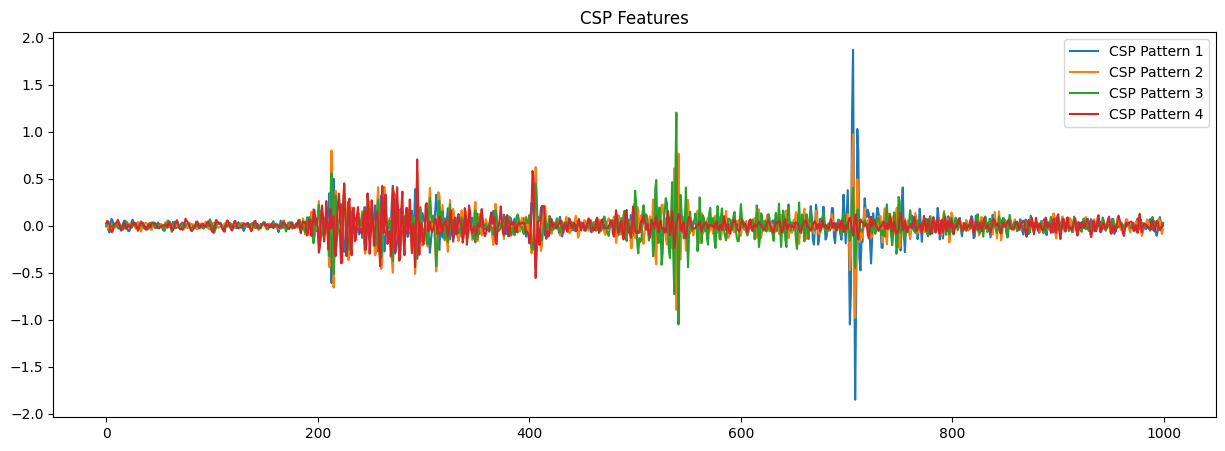

In [125]:
# Plot the CSP features
plt.figure(figsize=(15, 5))
for i in range(component_num):
    plt.plot(csp_obj.patterns_[i], label=f'CSP Pattern {i+1}')
plt.legend()
plt.title('CSP Features')
plt.show()

## Classification

The first step here is to normalize (standardize) the newly segmented data and then split it into train/test sets with 75-25 ratio. This will be done such that the relative ratio between the frequency of the two classes is maintained in both of the train and data sets.

### Normalization and Train/Test Split

In [126]:
# Split 75-25.
X_train, X_test, y_train, y_test = train_test_split(csp_data, labels,\
    train_size=0.75, random_state=35, stratify=labels)

In [138]:
print(X_train.shape)

(149, 4)


### Models


In [128]:
# List of classifiers to train
clf_list = [SVC(kernel="linear", C=1)
            , SVC(kernel="rbf", C=1, gamma='auto')  
            , LogisticRegression()
            , MLPClassifier(hidden_layer_sizes=(100, 50, 10), alpha=0.05)]

clf_names =  [ "Support Vector Machien with Linear Kernel"
             , "Support Vector Machien with RBF Kernel"
             , "Logistic Regression"
             , "Multilayer Perceptron"]

# Go through each classifier
for clf, clf_name in zip(clf_list, clf_names):
    # Train on training set
    clf.fit(X_train, y_train)
    
    # Make prediction
    y_pred = clf.predict(X_test)
    
    # Evaluate model performance
    print(f'{clf_name} Accuracy: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred))

Support Vector Machien with Linear Kernel Accuracy: 0.96
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96        25
           1       1.00      0.92      0.96        25

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

Support Vector Machien with RBF Kernel Accuracy: 0.98
              precision    recall  f1-score   support

          -1       0.96      1.00      0.98        25
           1       1.00      0.96      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

Logistic Regression Accuracy: 0.96
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96        25
           1       1.00      0.92      0.96        25

    accuracy                        

C:\Users\Sardar Rajabzadeh\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [129]:
print(csp_data.shape)
print(X_train.shape)

(199, 4)
(149, 4)


## Clustering

### KMeans

In [143]:
#Create a k-means model with specific number of clusters
number_clusters = 50
kmeans = KMeans(n_clusters=number_clusters, init='k-means++', max_iter=300, random_state=None)

In [144]:
#Fit for kmeans clustering
kmeans.fit(csp_data)

KMeans(n_clusters=50)

In [145]:
#Get labels
pred_labels_kmeans = kmeans.labels_

#Get Centroids 
centroids_kmeans = kmeans.cluster_centers_

In [146]:
# Homogeneity
homogeneity_kmeans = homogeneity_score(labels_true=labels, labels_pred= pred_labels_kmeans)
print(homogeneity_kmeans)

0.8697657334466692


In [134]:
# Silhouette
silhouette_score_kmeans = silhouette_score(csp_data,pred_labels_kmeans)
print(silhouette_score_kmeans)

0.21276707383886004


### DBScan

In [135]:
#Create DBSCAN model for clustering
dbscan = DBSCAN(eps=5, min_samples=15, metric='chebyshev')

In [136]:
#Fit for dbscan clustering
#dbscan.fit(cosine_distances(csp_data))
dbscan.fit(csp_data)

DBSCAN(eps=5, metric='chebyshev', min_samples=15)

In [137]:
#Get labels and number of clusters
pred_labels_dbscan = dbscan.labels_
number_clusters_dbscan = len(np.unique(pred_labels_dbscan)) - 1
print(number_clusters_dbscan)
print(pred_labels_dbscan)

1
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0]


In [147]:
# Homogeneity
homogeneity_dbscan = homogeneity_score(labels_true=labels, labels_pred= pred_labels_dbscan)
print(homogeneity_dbscan)

0.010197830781075877


In [149]:
# Silhouette
silhouette_score_dbscan = silhouette_score(csp_data,pred_labels_dbscan)
print(silhouette_score_dbscan)

0.8190386956098066
